## Формулировка задачи и описание модели

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
%matplotlib inline

Перед нами стоит задача написания трехслойного перцептрона (с одним скрытым слоем) для классификации картинок размера 28x28 (рукописные цифры) из набора данных `MNIST`, который будет в качестве ответа выдавать число, которое изображено на картинке. 
Мы задаем многослойный перцептрон как сложную функцию, в которой используются линейные операции и поточечные нелинейные преобразования. Если входные данные (признаковое описание объекта) заданы вектором $x$, то функция перцептрона с одним скрытым слоем выглядит следующим образом:
$$
F(x) = \Psi\left(\phi\left( {x}\cdot\theta_1 + b_1 \right)\cdot\theta_2 + b_2\right),
$$
где $x$ имеется в виду без дополнительного единичного признака; $\phi$ - функция активации скрытого слоя; $\Psi$ - функция активации выходного слоя перцептрона.

- в качестве функции активации $\Psi$ мы будем использовать `softmax`:
$$
\Psi(h_i) = \frac{e^{h_i}}{\sum_{j=1}^{K}{e^{h_j}}}
$$
- в качестве функции активации $\phi$ мы будем использовать `ReLu`:
$$
\phi(h_i) = \max\left(0, x\right)
$$

## Формулирвока функции потерь, метода оптимизации и меры качества модели

- в качестве функции потерь мы будем использовать перекрестную энтропию в многоклассовом варианте (приведено в записи для одного объекта), так как целевая переменная имеет мультимиальное распределение:
$$
{\mathscr{L}}\left(\hat{y},y\right) = -\sum_{j=1}^{K}{y_j*ln\left(\hat{y}_j\right)}, 
$$
где $\hat{y}=F(x)$,
${K}$ = 10 (количество цифр 0, .. ,9)

Вычислять градиент функции потерь по параметрам мы будем с помощью back propagation (метод вычисления градиента, который используется при обновлении весов многослойного перцептрона), если объяснить в двух словах - это просто градиент сложной функции.

В каждом нейроне мы можем посчитать производную выхода этого нейрона по входу этого нейрона. Таким образом, передавая значение производной к предыдущему нейрону, мы реализуем вычисление производной сложной функции, в конце получив значение градиента функции потерь по параметрам.

$$\frac{\partial L(\theta, x)}{\partial \theta_1} = \frac{\partial L(\theta, x)}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial \theta_1} = \frac{\partial L(\theta, x)}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial Softmax} ...$$

Обучаемыми параметрами сети являются все веса, с которыми суммируются входы всех нейронов. Будем обучать их методом стохастического градентного спуска.

Стохастический градиентный спуск отличается от простого градиентного спуска тем, что мы разделяем выборку на batch'и и вычисляем градиент не на всей выборке, а лишь на ее части. Это работает в том случае, если выборка слишком большая (обычный градиентный спуск займет слишком много времени и памяти) и данные порождены каким-то одним распределением. В нашей задаче мы как раз-таки предполагаем, что данные порождены одним распределением и поэтому можно использовать для оценки градиента только часть данных.



* Сформулируем меру качества модели (accuracy score). Так как у нас нет дисбаланса в распределении целевой переменной(увидим далее):
$$
score = \frac{1}{N}\sum_{i=1}^{N}{y_i}==\hat{y_i}_k, \text{    }{k} = argmax\hat{y}
$$

## Формулировка признакового описания объектов, их преобразование и визуализация

In [6]:
mnist = np.load('./mnist.npz')
X_train = mnist['x_train']
y_train = mnist['y_train']
X_test = mnist['x_test']
y_test = mnist['y_test']

Посмотрим на то, как выглядят наши данные, возьмем рандомную картинку

8


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  13,  94, 254, 254,
        254, 208, 255, 236,  30,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 114, 253, 253, 253,
        253, 253, 253, 253, 237,  68,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

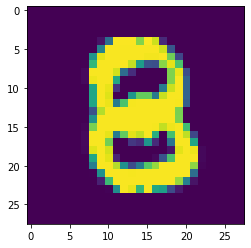

In [11]:
random_number = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[random_number])
print(y_train[random_number])
X_train[random_number]

Распределение целевой переменной(количество каждой цифры). Как мы, видим таргет распределен равномерно, как раз отсюда следует, что метрика accuracy будет работать хорошо

/Users/ildarhabutdinov/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

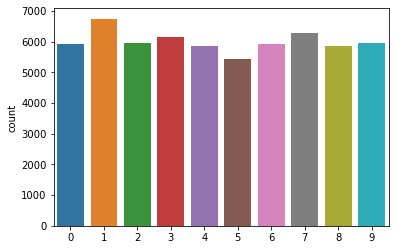

In [5]:
sns.countplot(y_train)

Посмотрим на размерность наших данных

In [6]:
print('Размер X_train', X_train.shape)
print('Размер y_train', y_train.shape)
print('Размер X_test', X_test.shape)
print('Размер y_test', y_test.shape)

Размер X_train (60000, 28, 28)
Размер y_train (60000,)
Размер X_test (10000, 28, 28)
Размер y_test (10000,)


  Так как наши признаки представлены в виде трехмерного тензора Nx28x28, то для работы с ними нам нужно преобразовать его в двумерный тензор 
Nx784, где N - количество объектов

In [7]:
# Reshape (60000, 28, 28) -> (60000, 10)
X_train = X_train.reshape((X_train.shape[0], 784))
X_test = X_test.reshape((X_test.shape[0], 784))

* Наши целевые значения мы закодируем с помощью one hot encoding'a и получим вектор, состоящий из 10 элементов - нулей и единиц. Единица стоит на месте, индекс которого является классом, к которому относится данный таргет, а предсказанием алгоритма является вектор из вероятнотстей принадлежности каждому клаассу. Эти самые вероятности мы получаем после действия функции активации `softmax`.
* Наши признаки мы нормируем на отрезок [0,1], формула:
$
x = \frac{x - x_{min}}{x_{max} - x_{min}}
$

In [8]:
def Scaler(X):
    """
    Нормализация признаков, воизбежание деления на ноль, используем очень маленькое значение epsilon
    """
    epsilon = 1e-100
    return (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0) +
                                      epsilon)


def OneHotEncoding(y):
    """
    Кодируем таргеты с помощью one hot encoding
    """
    assert len(y.shape) == 1

    y_coded = np.zeros((y.shape[0], np.max(np.unique(y)) + 1))

    for i in range(len(y)):
        y_coded[i][y[i]] = 1
    return y_coded


def accuracy_score(y_true, y_pred):
    """
    Размерность y_true (object_counts, 10)
    Размерность y_pred (object_counts, 10)
    """
    assert y_true.shape == y_pred.shape
    acc = 0
    for i in range(y_true.shape[0]):
        if np.argmax(y_true[i]) == np.argmax(y_pred[i]):
            acc += 1
    return acc / y_pred.shape[0]

In [9]:
X_train_scaled = Scaler(X_train)
X_test_scaled = Scaler(X_test)
y_train_coded = OneHotEncoding(y_train)
y_test_coded = OneHotEncoding(y_test)

In [10]:
class Differentiable:
    def __init__(self):
        pass

    def forward(self, **kwargs):
        raise NotImplementedError()

    def backward(self, **kwargs):
        raise NotImplementedError()

In [11]:
class loss(Differentiable):
    def __init__(self):
        super(loss, self).__init__()

    def forward(self, y_true, y_pred):
        """
        функция возвращает скаляр - значение loss'a
        """
        self.cache = y_pred
        loss_value = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        return loss_value

    def backward(self, y_true, y_pred):
        """
        размерность возвращаемого градиента: (batch_size, 10)
        """
        partial_grad = -y_true / (self.cache)

        return partial_grad

In [12]:
class Linear(Differentiable):
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()
        """
        in_features: количество признаков на входе
        out_features: количество признаков на выходе
        """
        self.out_features = out_features
        self.in_features = in_features
        np.random.seed(42)
        self.theta = np.random.randn(self.in_features,
                                     self.out_features) * 0.001
        self.bias = np.zeros(out_features)
        self.cache = None

    def forward(self, X):
        """
        Под действием линейного преобразования должен происходить reshape (batch_size, in_features) -> (batch_size, out_features)
        """
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert X.shape[1] == self.in_features
        self.cache = X

        y_pred = X @ self.theta + self.bias
        return y_pred

    def backward(self, upstream, lr):
        """
        размерность возвращаемого градиента:
        self.linear: (batch_size, 784)
        self.linear_2: (batch_size, batch_size)
        """
        self.dw = np.dot(self.cache.T, upstream)
        self.dx = np.dot(upstream, self.theta.T)
        self.db = upstream.sum(axis=0)

        self.theta -= lr * self.dw
        self.bias -= lr * self.db

        return self.dx

In [13]:
class Activation(Differentiable):
    def __init__(self):
        super(Activation, self).__init__()
        self.cache = None

    def forward(self, X):
        """
        Размерность не должна поменяться, то есть (batch_size, batch_size) -> (batch_size, batch_size)
        """
        self.cache = X
        y_pred = np.maximum(0, X)
        assert y_pred.shape == X.shape
        return y_pred

    def backward(self, upstream):
        """
        Размерность возвращаемого градиента: (batch_size, batch_size)
        """
        upstream = np.multiply(upstream, self.cache > 0)
        return upstream

In [14]:
class Softmax(Differentiable):
    def __init__(self):
        super(Softmax, self).__init__()
        self.state = None

    def forward(self, X):
        """
        Не меняет размера матрицы, то есть остается (batch_size, 10) 
        """
        self.cache = X
        z = X - np.max(X, axis=1, keepdims=True)
        y_pred = np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
        self.state = y_pred
        return y_pred

    @staticmethod
    def jacobian(x):
        '''
        Возвращает якобиан Softmax'a, который выражается через сам Softmax.
        '''
        x = x.reshape(-1, 1)
        return np.diagflat(x) - np.dot(x, x.T)

    def backward(self, output_grad):
        """
        размерность возвращаемого градиента: (batch_size, 10)
        """
        output = self.state[:, np.newaxis]
        jacob = np.squeeze(
            np.apply_along_axis(Softmax.jacobian, axis=2, arr=output))
        output_grad_tr = output_grad[:, np.newaxis]
        self.input_grad = np.squeeze(output_grad_tr @ jacob)
        return self.input_grad

In [15]:
class Perceptron(Differentiable):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.linear = Linear(784, 256)
        self.activation = Activation()
        self.linear_2 = Linear(256, 10)
        self.softmax = Softmax()

    def forward(self, X):
        """
        Реализуем прямой проход
        """
        y_pred = self.linear.forward(X)
        y_pred = self.activation.forward(y_pred)
        y_pred = self.linear_2.forward(y_pred)
        y_pred = self.softmax.forward(y_pred)

        return y_pred

    def backward(self, upstream, lr):
        """
        Реализуем обратный проход
        upstream: градиент сложной функции
        """
        upstream = self.softmax.backward(upstream)
        upstream = self.linear_2.backward(upstream, lr)
        upstream = self.activation.backward(upstream)
        upstream = self.linear.backward(upstream, lr)
        return upstream

In [16]:
def generate_batches(X, y, batch_size):
    """
    Разделение данных на батчи
    """
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))
    amount_batches = len(perm) // batch_size

    for i in range(amount_batches):
        yield (X[perm[i * batch_size:(i + 1) * batch_size]],
               y[perm[i * batch_size:(i + 1) * batch_size]])

In [19]:
def train_loop(X, y, X_test, y_test, model, loss_fn, epochs=100):
    """
    Возвращает:
    loss_history: эволюция лосса
    best_model: модель с самым высоким score на тестовой выборке
    """
    pbar = tqdm(total=epochs)
    train_loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []
    lr = 0.001
    batch_size = 256
    acc_train = []
    best_model = None
    current_accuracy = 0
    for i in range(epochs):
        for X_batch, y_batch in generate_batches(X, y, batch_size):
            y_pred = model.forward(X_batch)
            loss_value = loss_fn.forward(y_batch, y_pred)
            upstream = loss_fn.backward(y_batch, y_pred)
            grad = model.backward(upstream, lr)

        train_loss_history.append(loss_fn.forward(y, model.forward(X)))
        test_loss_history.append(loss_fn.forward(y_test,
                                                 model.forward(X_test)))

        train_accuracy = accuracy_score(y, model.forward(X))
        test_accuracy = accuracy_score(y_test, model.forward(X_test))

        train_accuracy_history.append(train_accuracy)
        test_accuracy_history.append(test_accuracy)

        #выбираем лучшую модель по ОБУЧАЮЩЕЙ ВЫБОРКЕ.
        if train_accuracy > current_accuracy:
            current_accuracy = train_accuracy
            best_model = model

        pbar.update(1)
        pbar.set_postfix({
            'train loss': train_loss_history[i],
            'test loss': test_loss_history[i]
        })

        print("loss value on {} epoch. Train score : {}. Test score : {}.".
              format(i, train_accuracy, test_accuracy))
    pbar.close()
    return (train_loss_history, test_loss_history, train_accuracy_history,
            test_accuracy_history, best_model)

In [20]:
obj_fn = loss()
model = Perceptron()
train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history, best_model = train_loop(
    X_train_scaled,
    y_train_coded,
    X_test_scaled,
    y_test_coded,
    model,
    obj_fn,
    epochs=30)

loss value on 0 epoch. Train score : 0.8996166666666666. Test score : 0.9004.
loss value on 1 epoch. Train score : 0.9239. Test score : 0.9242.
loss value on 2 epoch. Train score : 0.9389833333333333. Test score : 0.9384.
loss value on 3 epoch. Train score : 0.9486166666666667. Test score : 0.9472.
loss value on 4 epoch. Train score : 0.9555833333333333. Test score : 0.9535.
loss value on 5 epoch. Train score : 0.9618166666666667. Test score : 0.9577.
loss value on 6 epoch. Train score : 0.9666. Test score : 0.9612.
loss value on 7 epoch. Train score : 0.9706333333333333. Test score : 0.9642.
loss value on 8 epoch. Train score : 0.9738833333333333. Test score : 0.9675.
loss value on 9 epoch. Train score : 0.9766166666666667. Test score : 0.9693.
loss value on 10 epoch. Train score : 0.9786833333333333. Test score : 0.9708.
loss value on 11 epoch. Train score : 0.9801833333333333. Test score : 0.972.
loss value on 12 epoch. Train score : 0.9817166666666667. Test score : 0.9738.
loss val

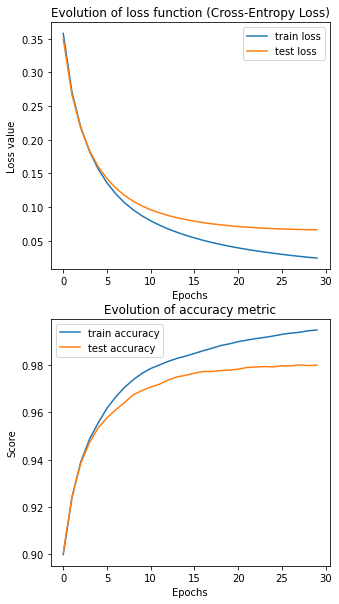

In [21]:
fig, axs = plt.subplots(nrows=2, figsize=(5, 10))

axs[0].plot(train_loss_history, label='train loss')
axs[0].plot(test_loss_history, label='test loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss value')
axs[0].set_title('Evolution of loss function (Cross-Entropy Loss)')
axs[0].legend()

axs[1].plot(train_accuracy_history, label='train accuracy')
axs[1].plot(test_accuracy_history, label='test accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Score')
axs[1].set_title('Evolution of accuracy metric')
axs[1].legend()

## Оценка качества модели на валидационной выборке и сравнение со значениями оценки качества модели на обучающей выборке

В best_model находится модель с параметрами, лучше всего показавшими себя на обучающей выборке по метрике accuracy. Протестируем ее на валидационной выборке. Наша модель обучалась исключительно за счет обучающей выборки, значения на валидационной выборке были вычислены лишь для сравнения оценок модели на этих двух выборках в процессе обучения.

In [22]:
#Применим нашу модель
y_pred_train = best_model.forward(X_train_scaled)
y_pred_test = best_model.forward(X_test_scaled)

Значения функции потерь на обучающей и валидационной выборке одинаково низкие, что говорит нам о хорошем обучении.

In [23]:
train_loss = obj_fn.forward(y_train_coded, y_pred_train)
test_loss = obj_fn.forward(y_test_coded, y_pred_test)
print('loss of train: ', train_loss, ' loss of test: ', test_loss)

loss of train:  0.024215944694159584  loss of test:  0.06626879700904294


Как мы можем заметить доля правильных ответов ~0.995 на тренировочной выборке и 0.9801 на тестовой. Я считаю это хорошим результатом, так как в 98% случаев наша модель верно классифицирует изображения.

In [25]:
train_accuracy = accuracy_score(y_train_coded, y_pred_train)
test_accuracy = accuracy_score(y_test_coded, y_pred_test)
print('train accuracy: ', train_accuracy, '\n', 'test accuracy: ',
      test_accuracy)

train accuracy:  0.9950666666666667 
 test accuracy:  0.9801


## Выводы

Целью работы было реализовать модель трехслойного перцептрона для классификации dataset'a MNIST методом обратного распространения для подсчета градиента функции потерь по весам и SGD для оптимизации весов.

Как мы смогли заметить, наша модель показывает низкие значения функции потерь и высокую точность (~98%), и на тренировочной, и на тестовой выборке, что свидетельствует о качественном обучении модели и отсутствии переобучения/недообучения и наличии достаточного количества данных. Отсюда мы можем сделать вывод о том, мы справились с поставленной задачей.
